In [3]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
import pprint
import metis
import pickle

In [4]:
# 파일 불러오기
with open('../../data/python_df.pkl', 'rb') as f:
    df = pickle.load(f)


In [5]:
# 파일 불러오기
with open('../../data/python_df_qna.pkl', 'rb') as f:
    df_qna = pickle.load(f)

In [6]:
print(df['q_owneruserid'].min())
print(df['q_owneruserid'].max())

116
23031413


## 유저 별 질문/답변 횟수를 히스토그램으로 출력 
* 대부분의 유저들이 질문과 답변을 안한다는 것을 알 수 있음 

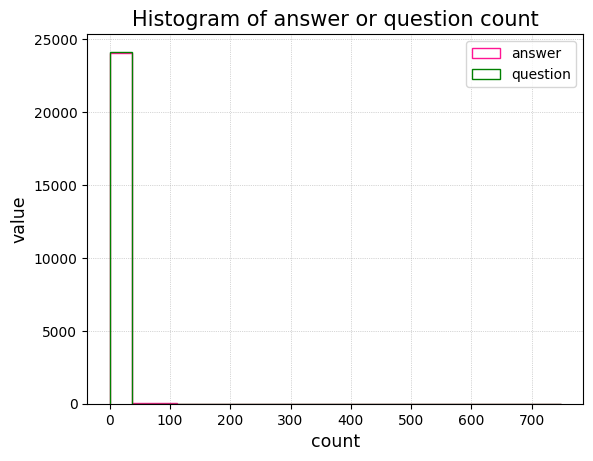

In [7]:
fig, ax = plt.subplots()

ax.hist([df_qna['question_cnt'], df_qna['answer_cnt']], # specify data
        bins = 20, # number of bins
        color = ['green', 'deeppink'], # bar color
        histtype = 'step', # type of histogram
        label = ['question', 'answer']) # create legened labels

ax.set_title('Histogram of answer or question count', fontsize = 15) # title
ax.set_xlabel('count', fontsize = 12.5) # x-axis label
ax.set_ylabel('value', fontsize = 12.5) # y-axis label

ax.legend(loc = 'upper right', fontsize = 10) # add legend

ax.grid(True, linestyle = ':', linewidth = 0.5) # grid

plt.show();

## 같은 데이터를 활용하여 누적분포 함수 시각화
* 질문횟수와 답변횟수가 비슷한 기울기를 보이다가, 질문횟수가 답변횟수보다 먼저 1로 수렴 
* 답변횟수보다 질문횟수가 0에 더 가깝다는것을 알 수 있음

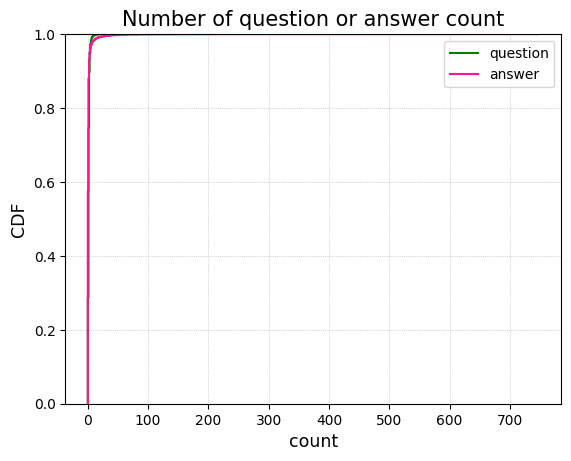

In [8]:
### cdf plot for multiple groups

fig, ax = plt.subplots()

sns.ecdfplot(x = df_qna['question_cnt'],
             color = 'green',
             label = 'question',
             ax = ax)
sns.ecdfplot(x = df_qna['answer_cnt'],
             color = 'deeppink',
             label = 'answer',
             ax = ax)

ax.set_title('Number of question or answer count', fontsize=15)
ax.set_xlabel('count', fontsize = 12.5)
ax.set_ylabel('CDF', fontsize = 12.5)

ax.legend(loc = 'upper right', fontsize = 10)

ax.grid(True, linestyle=':', linewidth = 0.5)

plt.show();

## 유저 별 답변비율 시각화
* 위의 그래프를 보면 대부분의 유저들이 질문도 답볃도 하지 않는 상황
* 그럼 유저별로 질문 답변 횟수 사이에 차이가 존재하는지 비율로 확인 
* (유저별 질문횟수)/(유저별 질문횟수+유저별 답변횟수)
* 대부분의 유저들이 거의 답변을 하지 않고, 몇몇의 유저들이 답변만 하는 것을 알 수 있음

In [9]:
df_qna['question_rate'] = np.round(df_qna['question_cnt']/(df_qna['question_cnt']+df_qna['answer_cnt'])*100, 2)

In [10]:
df_qna['answer_rate'] = 100-df_qna['question_rate'] 

Text(0, 0.5, 'Number of Users')

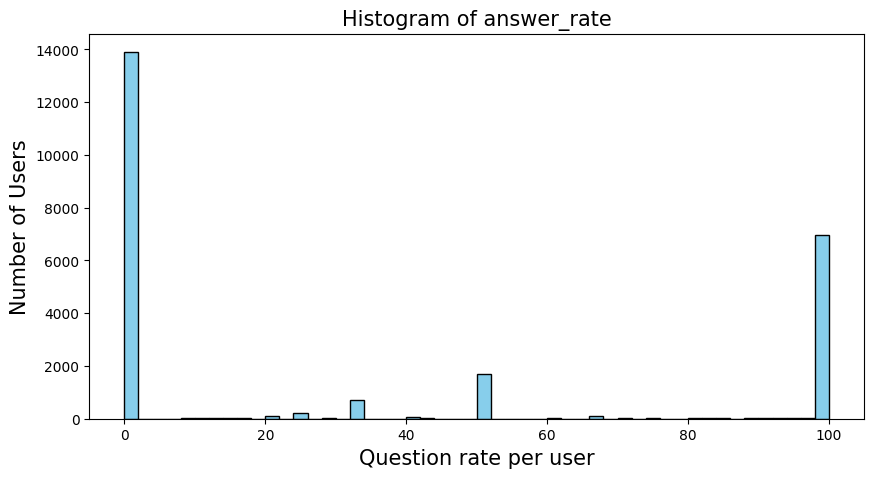

In [11]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))

axs.hist(df_qna['answer_rate'] , # plot the original histogram
         bins = 50,
         color = 'skyblue',
         edgecolor = 'black')
axs.set_title('Histogram of answer_rate', fontsize = 15)
axs.set_xlabel('Question rate per user', fontsize = 15)
axs.set_ylabel('Number of Users', fontsize = 15)



In [12]:
df_qna

,user_id,question_cnt,answer_cnt,question_rate,answer_rate
0,116,2.0,0.0,100.0,0.0
1,476,0.0,11.0,0.0,100.0
2,1527,0.0,4.0,0.0,100.0
3,2988,0.0,2.0,0.0,100.0
4,3063,0.0,1.0,0.0,100.0
...,...,...,...,...,...
24134,23030687,1.0,1.0,50.0,50.0
24135,23030938,1.0,0.0,100.0,0.0
24136,23031306,0.0,1.0,0.0,100.0
24137,23031346,1.0,0.0,100.0,0.0


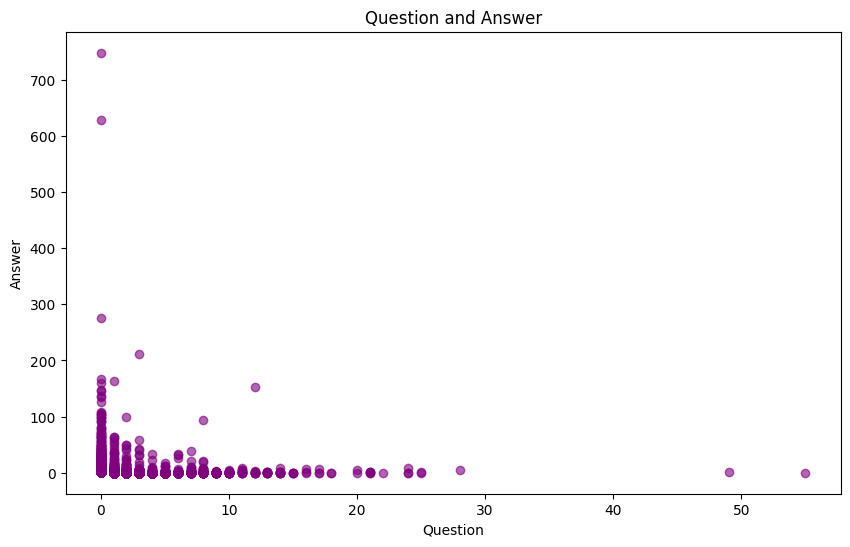

In [13]:
fig_scatter_reg, ax = plt.subplots(figsize = (10, 6))

ax.scatter(df_qna['question_cnt'], df_qna['answer_cnt'], color = 'purple', alpha = 0.6)

ax.set_title('Question and Answer')
ax.set_xlabel('Question')
ax.set_ylabel('Answer')


plt.show();

## 질문 혹은 답변 횟수가 0인 유저 별 비율 시각화
* 그래프를 보면 어떤 수치든 양극단의 비율이 높음(정규분포를 띄지 않음)
* 극단에 존재하는 유저(답변횟수가 0 이거나 질문 횟수가 0)들을 대상으로 시각화 진행
* 한번도 질문하지 않은 유저는 10706명, 한번도 답변하지 않은 유저는 23442명으로 답하지 않은 유저가 약 2.18 배 많음 
* 한번도 답변하지 않은 유저의 경우 모두 25회 미만으로 질문하였지만, 한번도 대답하지 않은 유저의 경우 분산이 크며 경우에 따라 200회 이상 답변한 유저도 존재 
* 답변하는 유저가 더 적은 수지만 훨씬 더 활발하게 활동한다는것을 알 수 있음 

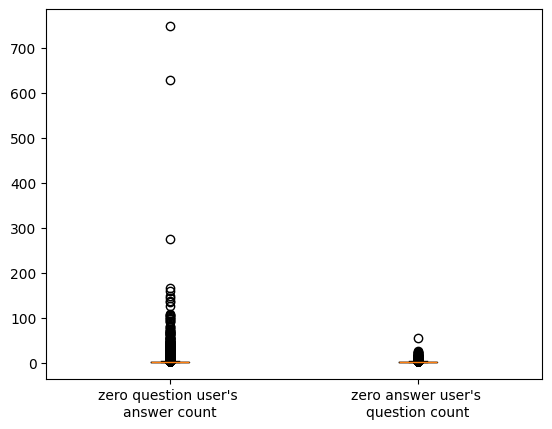

In [14]:
zero_q_cnt = df_qna.loc[df_qna['question_cnt']==0, 'answer_cnt']
zero_a_cnt = df_qna.loc[df_qna['answer_cnt']==0, 'question_cnt']

fig,ax = plt.subplots()
ax.boxplot([zero_q_cnt,zero_a_cnt])
# plt.title('Species_bill_length')
plt.xticks([1,2],['zero question user\'s \nanswer count', 'zero answer user\'s \nquestion count'])
plt.show();

In [15]:
print(len(zero_q_cnt))
print(len(zero_a_cnt))
print(len(zero_a_cnt)/len(zero_q_cnt))

6941
13899
2.002449214810546


In [16]:
q_reputation = df[['q_owneruserid','q_reputation']].rename(columns = {'q_owneruserid':'user_id', 'q_reputation':'reputation'})
a_reputation = df[['a_owneruserid','a_reputation']].rename(columns = {'a_owneruserid':'user_id', 'a_reputation':'reputation'})

In [17]:
df_reputation = pd.concat([q_reputation, a_reputation], axis = 0).drop_duplicates()

In [18]:
df_qna = pd.merge(df_qna, df_reputation, on = 'user_id', how='left')

In [19]:
df_qna.isna().sum()

user_id          0
question_cnt     0
answer_cnt       0
question_rate    0
answer_rate      0
reputation       0
dtype: int64

In [20]:
df_qna.sort_values(by = ['question_cnt'], ascending=False)

,user_id,question_cnt,answer_cnt,question_rate,answer_rate,reputation
19785,22466650,55.0,0.0,100.00,0.00,669
1524,1471980,49.0,1.0,98.00,2.00,10288
1469,1422096,28.0,4.0,87.50,12.50,42385
9213,12242085,25.0,0.0,100.00,0.00,2292
7627,10200497,25.0,1.0,96.15,3.85,1165
...,...,...,...,...,...,...
17265,21825949,0.0,3.0,0.00,100.00,52
7306,9746523,0.0,1.0,0.00,100.00,334
7307,9746974,0.0,1.0,0.00,100.00,49
7310,9750706,0.0,3.0,0.00,100.00,11747


In [21]:
df_qna.sort_values(by = ['answer_rate'], ascending=False)

,user_id,question_cnt,answer_cnt,question_rate,answer_rate,reputation
12069,15736724,0.0,2.0,0.0,100.0,56
6770,8927098,0.0,1.0,0.0,100.0,2611
13752,18044164,0.0,2.0,0.0,100.0,350
6791,8962746,0.0,1.0,0.0,100.0,434
6789,8959415,0.0,1.0,0.0,100.0,1072
...,...,...,...,...,...,...
11327,14826425,2.0,0.0,100.0,0.0,154
11330,14829049,1.0,0.0,100.0,0.0,21
11331,14829523,4.0,0.0,100.0,0.0,478
11333,14830021,3.0,0.0,100.0,0.0,5


In [22]:
zero_q_rep = df_qna.loc[df_qna['question_cnt']==0, 'reputation']

In [23]:
zero_a_rep = df_qna.loc[df_qna['answer_cnt']==0, 'reputation']


## 질문 혹은 답변 횟수가 0인 유저 별 stackoverflow 평판(reputation) 시각화
* reputation이 높아질수록 유저의 수도 적어짐
* 답변하는 유저가 더 적은 수지만 커뮤니티에서 평판을 쌓아간다는 것을 알 수 있음 


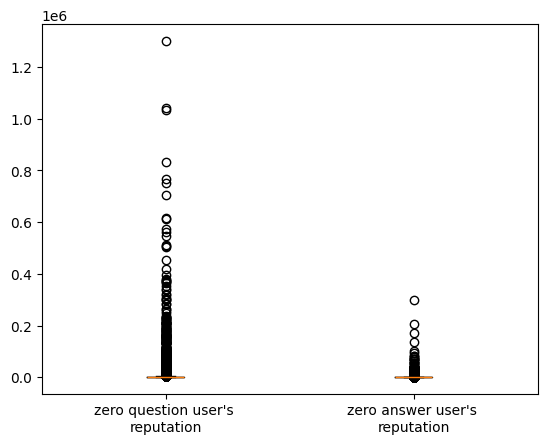

In [24]:
fig,ax = plt.subplots()
ax.boxplot([zero_q_rep,zero_a_rep])
# plt.title('Species_bill_length')
plt.xticks([1,2],['zero question user\'s \nreputation', 'zero answer user\'s \nreputation'])
plt.show();